In [0]:
# This is the code for our agent learning to play the Atari Centipede game
# This attempt involved rewarding the agent for taking shooting actions and for staying alive longer
!pip install gym #environments
!pip install gym[atari] 
!pip install keras #neural networks
!pip install matplotlib

In [0]:
import gym
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

from collections import deque

# Stored shooting/moving actions which we will use in reward function
shooting_actions = [1, 10, 11, 12, 13, 14, 15, 16, 17]
moving_actions = [10,11,12,13,14,15,16,17]

Using TensorFlow backend.


In [0]:
# Deep Q-learning Agent
# Adapted code from class
class DQNAgent:
    def __init__(self, env):
        self.env = env # environment
        self.state_size = len(env.observation_space.high) # number of state parameters
        self.action_size = env.action_space.n # number of possible actions
        self.memory = deque(maxlen=80000) # memory stores max of 10000 events
        self.gamma = 0.99    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.1 
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001 # for the neural net
        self.model = self._build_model() # untrained neural net
        self.time = 0
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim = self.state_size, activation='relu'))
        model.add(Dense(14, activation='relu'))
        model.add(Dense(self.action_size, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        # Store this experience in memory
        
        # Reward function based on shooting and staying alive
        if action in shooting_actions:
          reward = self.time*100
        else:
          reward = 0
        
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        # Act in an epsilon greedy manner
        self.time += 1
        if np.random.rand() <= self.epsilon:
            return env.action_space.sample()
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  
    
    def act_greedy(self, state):
        # Act in a greedy manner after environment is solved
        act_values = self.model.predict(state)
        return np.argmax(self.model.predict(state)[0]) 
    
    def replay(self, batch_size):
        # Learn from past experiences
        if batch_size > len(self.memory):
            return
        
        minibatch = random.sample(self.memory, batch_size) # Pick a random x amount of experiences to learn from
        for state, action, reward, next_state, done in minibatch:
            target = reward 
            # If we're at a terminal state, no need to look at next state
            if not done:
                # Standard value function
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target # alpha = 1 in this agent
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    def reset_time(self):
      self.time = 0
    
    def get_epsilon(self):
      return self.epsilon
      

In [0]:
# initialize gym environment and the agent
    env = gym.make('Centipede-ram-v0')
    agent = DQNAgent(env)
    episodes = 10000
    rewards = deque(maxlen=100)
    reward_list = []
    #Build Memory
    for _ in range(32):
        state = env.reset()
        state = np.reshape(state, [1, 128])
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, 128])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
        agent.reset_time()
    
    #Learn
    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, 128])
        done = False
        R = 0
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, 128])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            R += reward
            if done:
                agent.reset_time()
                print("episode: {}/{}, reward: {}, avg: {}, epsilon: {}"
                      .format(e+1, episodes, R, np.average(rewards), agent.get_epsilon()))
                rewards.append(R)
                reward_list.append(np.average(rewards))
                break
        if e > 500 and np.average(rewards) > 9000:
            print("Environment Solved")
            break
        agent.replay(75)

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode: 1/10000, reward: 1787.0, avg: nan, epsilon: 1.0
episode: 2/10000, reward: 1298.0, avg: 1787.0, epsilon: 0.995
episode: 3/10000, reward: 695.0, avg: 1542.5, epsilon: 0.990025
episode: 4/10000, reward: 1163.0, avg: 1260.0, epsilon: 0.985074875
episode: 5/10000, reward: 4776.0, avg: 1235.75, epsilon: 0.9801495006250001
episode: 6/10000, reward: 4088.0, avg: 1943.8, epsilon: 0.9752487531218751
episode: 7/10000, reward: 1242.0, avg: 2301.1666666666665, epsilon: 0.9703725093562657
episode: 8/10000, reward: 967.0, avg: 2149.8571428571427, epsilon: 0.9655206468094844
episode: 9/10000, reward: 975.0, avg: 2002.0, epsilon: 0.960693043575437
episode: 10/10000, reward: 1266.0, avg: 1887.888888888889, epsilon: 0.9558895783575597
episode: 11/10000, reward: 1019.0, avg: 1825.7, epsilon: 0.9511101304657719
episode: 12/10000, reward: 2576.0, avg: 1752.3636363636363, epsilon: 0.946354579813443
episode: 13/10000, reward: 2408.0, avg: 1821.0, epsilon: 0.9416228069143757
episode: 14/10000, reward:

In [0]:
!pip -q install pyopengl
!pip -q install pyvirtualdisplay
!pip -q install pyglet
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so

E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'


In [0]:
# Display our agent learning
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

frames = []
for i in range(1):
    obs = env.reset()
    obs = obs.reshape(1,128)
    done = False
    R = 0
    t = 0
    while not done:
        frames.append(env.render(mode = 'rgb_array'))
        action = agent.act_greedy(obs)
        obs, r, done, _ = env.step(action)
        obs = obs.reshape(1,128)
        R += r
        t += 1
    print('test episode:', i, 'R:', R)
env.render()

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

In [0]:
print(env.observation_space.high)

[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255]


In [0]:
import matplotlib.pyplot as plt
x = range(len(reward_list))


Text(0,0.5,'Running 100 average rewards')

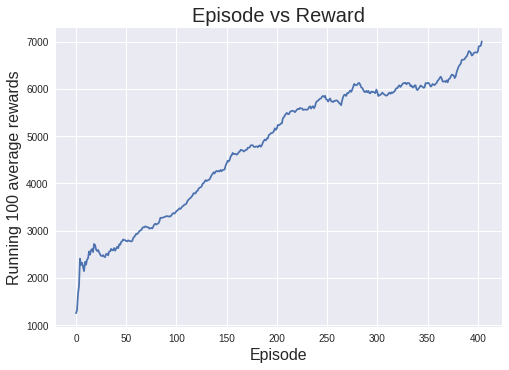

In [0]:
# Creating a graph of our episode vs. reward after running 100 average rewards
plt.plot(x, reward_list)
plt.title('Episode vs Reward', fontsize = 20)
plt.xlabel('Episode', fontsize=16)
plt.ylabel('Running 100 average rewards', fontsize=16)